# <center> <span style="color:purple"> Análisis de Componentes Independientes (ICA) para remoción de picos en Señales de Electroencefalograma (EEG) </span>
<span style="color:purple"> Descripción: </span>

En este notebook, se presenta un estudio sobre cómo utilizar el Análisis de Componentes Independientes (ICA) para procesar señales de electroencefalograma (EEG). El objetivo principal es eliminar los picos que corresponden al parpadeo del paciente durante el examen. El ICA es una técnica poderosa que permite descomponer una señal multivariada en componentes independientes, lo que facilita la identificación y eliminación de artefactos no deseados.

A lo largo del notebook, se explica la teoría detrás del ICA. Se muestra un ejemplo práctico de implementación utilizando bibliotecas de Python. Se exploran los resultados antes y después de aplicar el ICA, destacando la efectividad de la técnica para eliminar los picos de parpadeo y mejorar la calidad de las señales de EEG para su posterior análisis y diagnóstico.

### <span style="color:purple"> Breve teoría </span>
El Análisis de Componentes Independientes (ICA) es una técnica de procesamiento de señales y aprendizaje no supervisado que se utiliza para descomponer un conjunto de mezclas observadas en componentes subyacentes estadísticamente independientes. Matemáticamente, dado un conjunto de variables observadas X (mezclas), el ICA busca encontrar una matriz de pesos W y variables independientes S tal que su producto sea igual a los datos. Es decir, los datos pertenecientes a la mezcla se decompone en una combinación lineal. La relación se puede expresar como:

X = W * S
    
El objetivo principal del ICA es estimar la matriz de mezcla W, la cual permitirá descomponer las mezclas X en las fuentes independientes S. Sin embargo, el ICA tiene ciertas restricciones y supuestos. Uno de los supuestos clave es que las fuentes S deben ser estadísticamente independientes entre sí. Además, se asume que las fuentes son no gaussianas, lo que implica que sus distribuciones no siguen una curva de campana típica. Este supuesto de no gaussianidad es fundamental, ya que si todas las fuentes fueran gaussianas, el proceso de mezcla sería ambiguo, y múltiples combinaciones de fuentes podrían dar lugar a las mismas mezclas observadas, lo que dificultaría la separación única. También, el procedimiento requiere que los datos de mezcla tengan media cero y se emplee un método de blanqueamiento para eliminar la correlación en los datos. 
    
### <span style="color:purple">  Ejemplo: Remoción de picos en Señales de Electroencefalograma </span>

In [91]:
import h5py
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.decomposition import PCA
import numpy as np
from sklearn.decomposition import FastICA
import scipy.signal

Los archivos HDF5 (Hierarchical Data Format 5) son una forma de almacenar datos en una estructura jerárquica, similar a una base de datos.

In [15]:
with h5py.File('../Data_sets/EEG_data.mat', 'r') as f: #Abriendo el archivo. 'with' garantiza que el archivo se cerrará automáticamente al finalizar el bloque
    print(f.keys()) #Mostrando claves del archivo 
    data = f['Data'][:].T #Guardando valores transpuestos en un array
data.shape

<KeysViewHDF5 ['Data']>


(10001, 64)

# Visualizando los datos
Se tienen 10001 lecturas y 64 señales de los electrodos. Son muchos features, así que solamente graficamos las 4 primeras para formarnos una idea. 

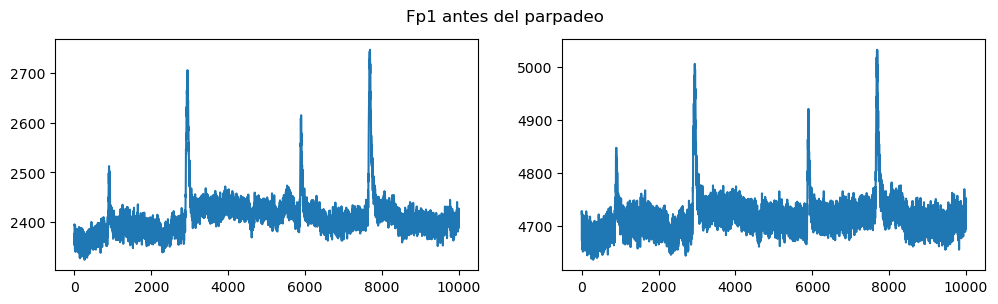

In [102]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,3))
#plt.subplots_adjust(wspace=0.2)
ax1.plot(data[:, 0])
ax2.plot(data[:, 1])

plt.suptitle("Fp1 antes del parpadeo")
plt.show()

El objetivo es eliminar los picos presentes en los datos, ya que estos provienen del parpadeo del paciente durante el procedimiento. Para esto, primero empleamos PCA para reducir la dimensión de los datos y posteriormente emplear ICA para separar las señales y poder identificar en cuál de estas variables independientes reside el parpadeo.

Empezamos por preparar los datos estandarizando:

In [55]:
x = data.copy()
scaler = StandardScaler()
x = scaler.fit_transform(x)
pd.DataFrame(x)

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,-0.362784,0.182904,-0.371285,-0.434231,-1.658346,-1.705161,-0.930909,-0.085866,-0.602488,1.464833,...,-1.728351,1.480079,0.365108,0.563518,0.382632,0.231905,-1.255966,-1.455526,1.550422,1.502441
1,-0.333166,0.309105,-0.221612,-0.360450,-1.397808,-1.623543,-0.668511,0.288056,-0.137023,1.697147,...,-1.639775,1.491328,1.174960,0.914031,0.637614,0.345506,-1.224105,-1.432755,1.737849,1.926525
2,-0.637916,-0.062130,-0.361792,-0.654785,-1.417312,-1.380047,-0.911576,0.152426,-0.467184,1.508463,...,-1.800590,0.739726,0.784575,0.366651,0.613671,0.186015,-1.457416,-1.367640,1.569396,1.442001
3,-1.060772,-0.613151,-0.806406,-1.077282,-1.930947,-1.428817,-1.634156,-0.631273,-1.305917,1.072990,...,-2.107858,-0.095702,-0.210295,-0.612204,0.353286,-0.258486,-1.788510,-1.492051,1.036074,0.612763
4,-1.221585,-0.895169,-0.953983,-1.280279,-2.061723,-1.367265,-1.809427,-0.854862,-1.502519,0.986455,...,-2.141725,-0.719146,-0.193545,-0.967953,0.200358,-0.511315,-1.949588,-1.286271,0.877170,0.276456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,-0.276291,-0.166870,0.983341,0.390967,-0.163665,1.101334,-0.359179,-0.020401,0.539744,-0.881315,...,1.059411,-0.973011,-0.023805,-0.210801,-0.573639,-0.637156,0.740151,-0.134882,0.402579,-2.466344
9997,0.126530,0.549570,1.114711,0.693158,-0.044501,0.784146,-0.069435,0.320487,0.898062,-0.749285,...,1.259217,0.362668,-0.052340,0.532350,-0.464116,-0.437736,1.124358,-0.352998,0.599556,-1.814195
9998,0.439248,0.937207,1.142763,0.828124,0.163727,0.545505,0.077345,0.464711,0.914508,-0.678503,...,1.349299,1.381169,0.647026,0.718868,-0.379195,-0.318496,1.353712,-0.652579,0.675637,-1.423318
9999,0.370258,0.793726,1.188179,0.932234,0.224380,0.676536,0.034099,0.394479,0.705530,-0.709282,...,1.301646,1.027291,0.924743,0.375295,-0.430815,-0.336283,1.281940,-0.676745,0.571594,-1.605326


### PCA para reducir dimensión

In [62]:
pca = PCA(n_components = 21)
PC = pca.fit_transform(x)
Pdf = pd.DataFrame(data = PC, columns = [f'C{i}' for i in range(21)])
Pdf

,C0,C1,C2,C3,C4,C5,C6,C7,C8,C9,...,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20
0,3.495827,-7.144348,2.647187,0.502949,0.627603,-2.363169,1.564998,0.121336,0.261927,0.473992,...,0.612211,0.181402,0.155897,-0.660139,-0.876807,0.001887,-0.147762,0.298887,-0.786251,0.123564
1,4.797626,-6.493670,3.026675,-0.160356,0.700792,-2.403145,1.659430,-0.188246,-0.047924,0.661277,...,0.979762,0.387238,0.007533,-0.135997,-0.826926,0.021192,-0.207698,0.327732,-0.979716,-0.037688
2,3.788467,-6.922204,1.538721,0.320407,0.806625,-2.472506,1.516617,-0.091176,-0.096309,0.648777,...,0.946103,0.500217,0.078752,0.122637,-0.628469,-0.041990,-0.279949,0.277428,-0.940653,-0.079534
3,0.818281,-8.597067,-0.187700,1.424464,0.840644,-2.278141,1.325659,-0.058184,0.148365,0.489364,...,0.762039,0.369829,0.294742,-0.227863,-0.232072,-0.056550,-0.194905,0.180645,-0.846343,-0.111738
4,0.110724,-8.951880,-1.552319,1.825788,1.123748,-1.926905,1.234071,-0.306315,0.288607,0.308362,...,0.899015,0.328804,0.288667,-0.483900,-0.151364,0.000456,-0.230784,0.098816,-0.779935,-0.098588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,-6.286654,4.740031,-0.955961,-1.024696,3.690022,0.370869,1.162592,1.974922,-0.286958,0.151486,...,-0.426368,0.183658,-0.118056,-0.011055,-0.143677,-0.276056,0.270580,0.362494,0.550531,-0.102029
9997,-4.904578,5.359389,1.817059,-1.646983,3.061076,0.135830,1.156995,1.840893,-0.449838,0.136724,...,-0.488036,-0.070109,-0.145153,-0.319736,-0.015655,-0.288146,0.201018,0.478116,0.610032,-0.055627
9998,-4.099883,5.597779,4.064085,-2.037982,2.637106,0.249565,1.137251,1.616774,-1.041792,0.480046,...,-0.236305,0.148197,-0.057615,-0.074665,-0.027397,-0.165843,0.126724,0.558964,0.525841,0.092352
9999,-4.193564,5.653592,3.606440,-1.662150,2.723183,0.224821,1.087628,1.607591,-1.376279,0.845332,...,-0.101645,0.574521,-0.088203,0.435038,-0.041226,-0.071234,0.140770,0.593071,0.622148,-0.002374


In [71]:
cum_var_exp = np.cumsum(pca.explained_variance_ratio_)*100 #Calcula la varianza acumulada explicada por las componentes principales
print(cum_var_exp)

[37.790783 72.559204 82.2205   87.66372  91.0243   92.892746 94.04252
 94.828354 95.56904  96.15139  96.53858  96.89451  97.210266 97.48008
 97.70672  97.925    98.12055  98.277534 98.40908  98.53073  98.64026 ]


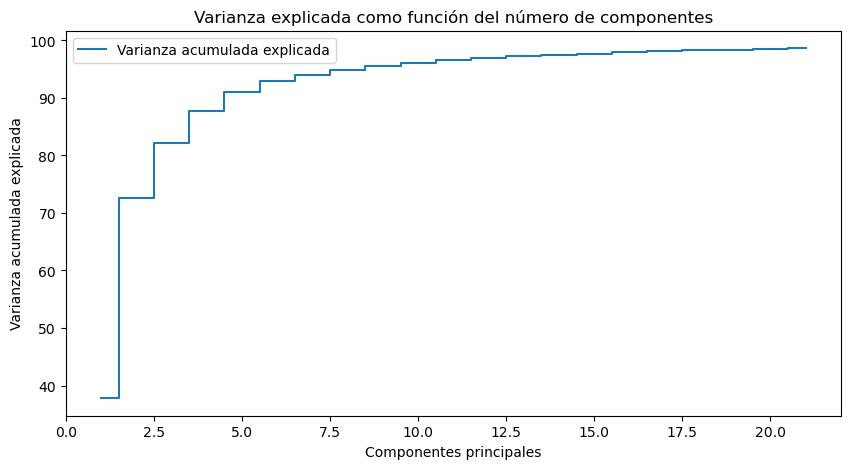

In [74]:
plt.figure(figsize=(10, 5))
plt.step(range(1, 22), cum_var_exp, where = 'mid', label='Varianza acumulada explicada')
plt.ylabel('Varianza acumulada explicada')
plt.xlabel('Componentes principales')
plt.legend(loc='best')
plt.title('Varianza explicada como función del número de componentes')
plt.show()

## ICA para aislar la señal deseada

In [78]:
ica = FastICA(n_components = 21, max_iter = 10000, whiten= 'unit-variance')
data_ica = ica.fit_transform(Pdf)
data_ica_sq = data_ica**2

In [79]:
data_ica.shape

(10001, 21)

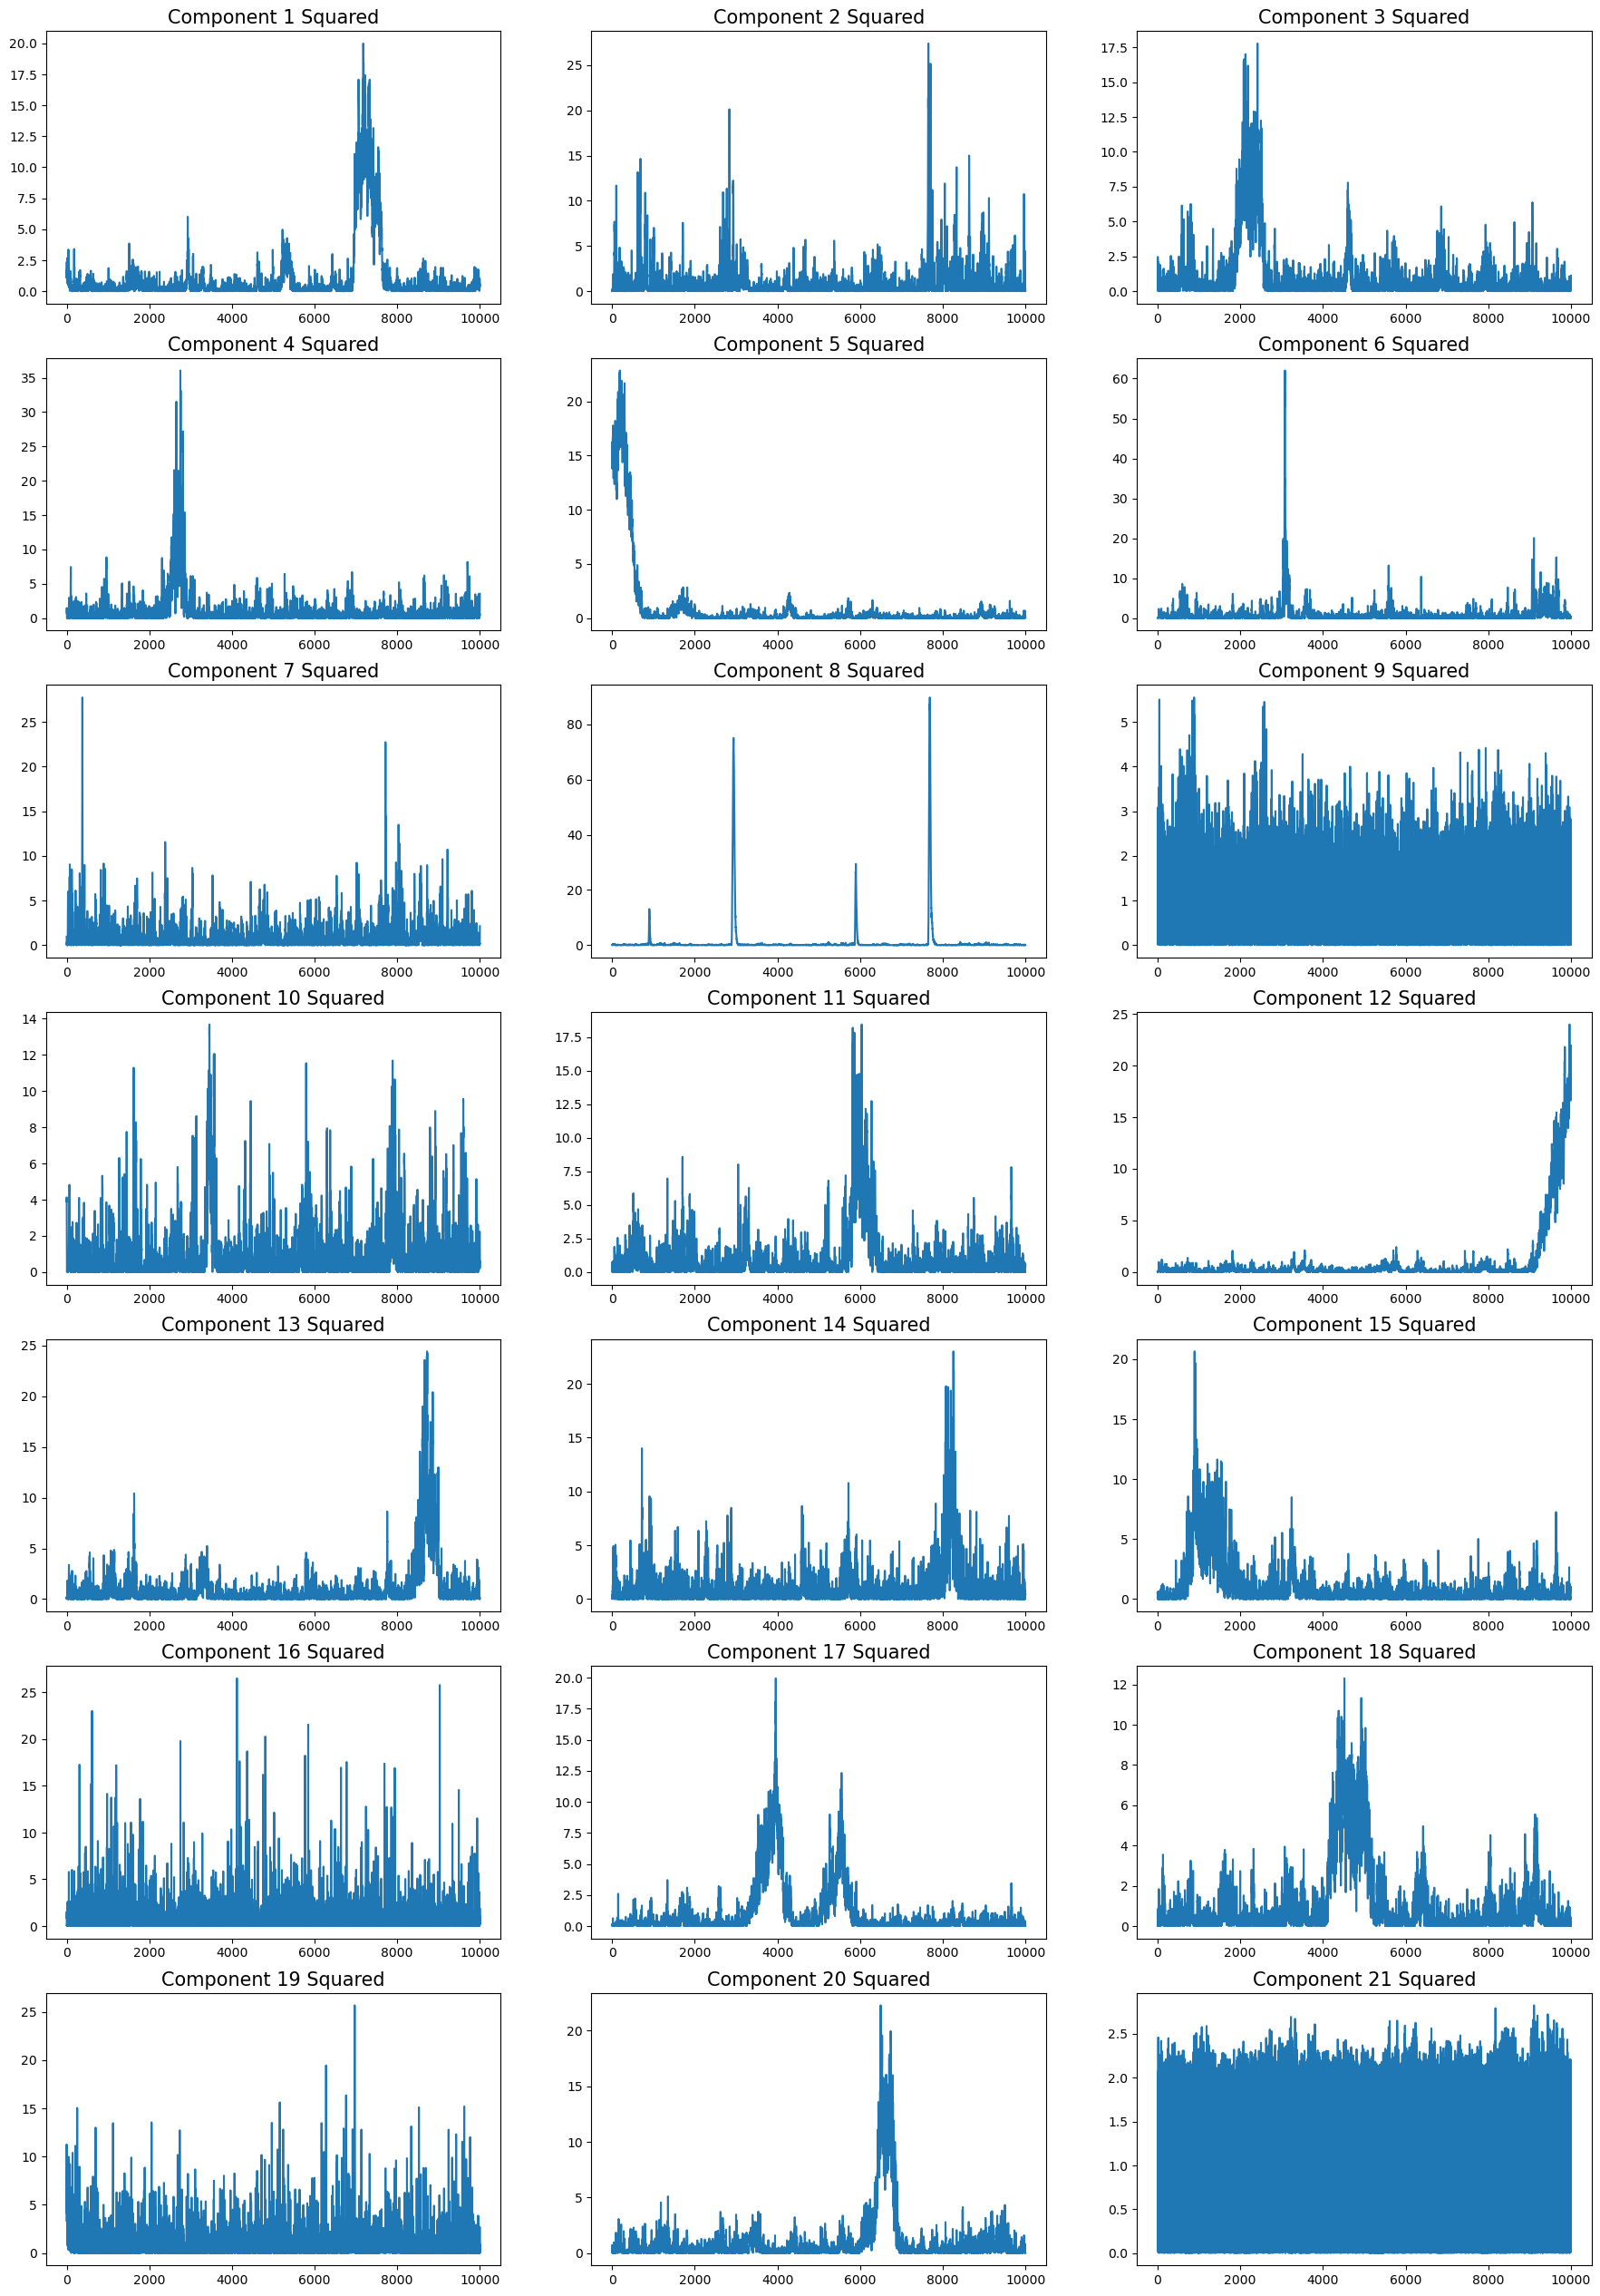

In [80]:
plt.figure(figsize=(22, 32))
for i in range(data_ica.shape[1]):
    plt.subplot(7, 3, i+1)
    plt.plot(data_ica_sq[:, i])
    plt.title(f'Component {i+1} Squared', fontsize =15)

### Eliminando parpadeos
La estrategia consiste en evaluar intervalos de una medida fija, en caso que hayan 4 picos (que son las señales iniciales que observamos) de valor mayor a 8, se elimina dicha variable independiente de los datos. 

In [107]:
blink = [] #Indica el índice de la variable/componenete independiente que contiene los parpadeos
for i in range(data_ica.shape[1]):
    pks = scipy.signal.find_peaks(data_ica[:, i]**2, distance= 100, prominence=8)
    if len(pks[0])==4:
        blink.append(i)

print(blink) 

[0, 7]


In [108]:
data_ica_clean = data_ica.copy()
data_ica_clean[:, blink]=0 #Eliminando las componeneter independientes que contienen el parpadeo

In [97]:
data_pca_no_blink = ica.inverse_transform(data_ica_clean)
data_no_blink = pca.inverse_transform(data_pca_no_blink)
data_no_blink_original = scaler.inverse_transform(data_no_blink)

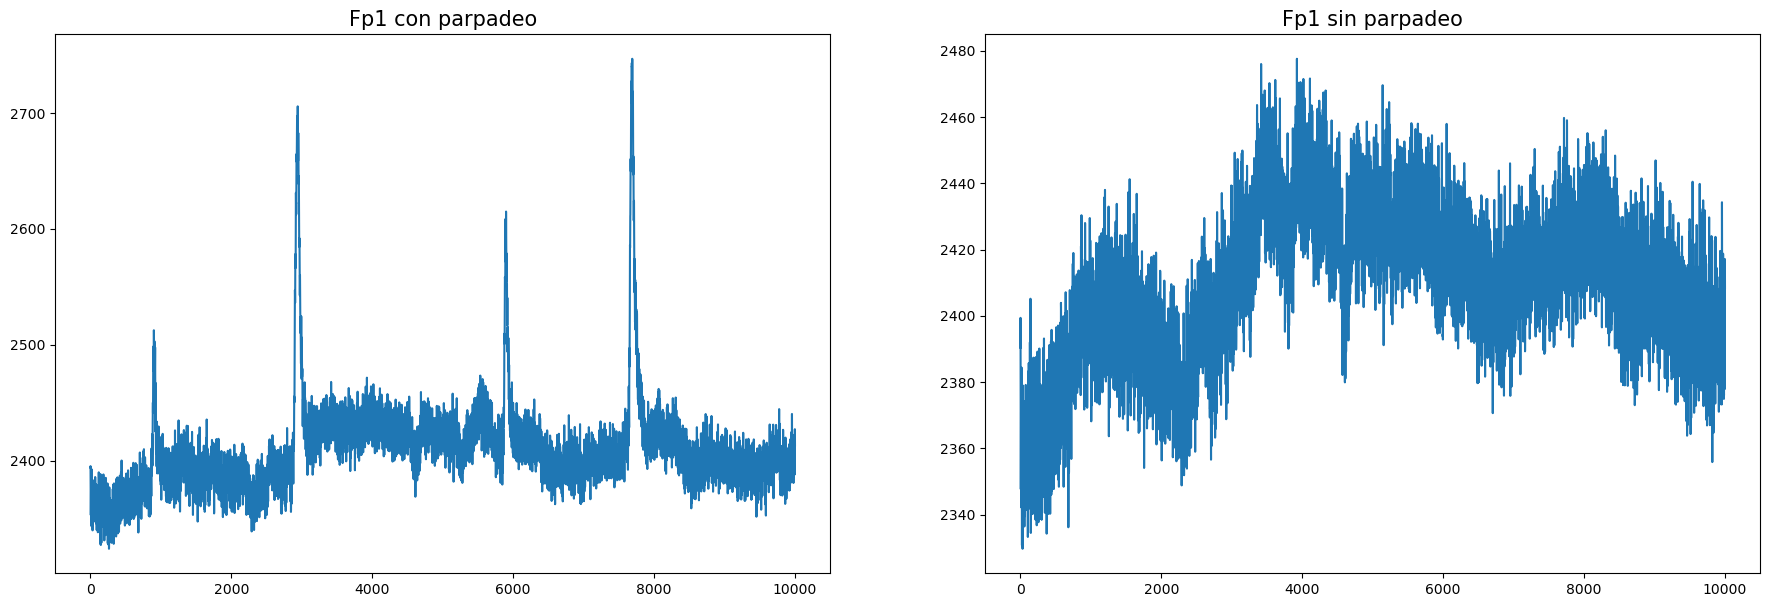

In [98]:
plt.figure(figsize=(22, 7 ))
plt.subplot(121)
plt.plot(data[:, 0])
plt.title('Fp1 con parpadeo', fontsize=15);
plt.subplot(122)
plt.plot(data_no_blink_original[:, 0])
plt.title('Fp1 sin parpadeo', fontsize=15);

<span style="color:purple"> Descripción: </span> La estrategia, aunque muy simple y poco sofisticado. fue efectiva a la hora de eliminar la señal de interés. Usando ICA fue posible determinar las componentes independientes que almacenaban la información del parpadeo en la señal original. 